In [1]:
!pip install -q qiskit>=0.43.1 qiskit-machine-learning>=0.9.0 scikit-learn matplotlib torch


In [2]:
!pip install -q qiskit-aer


In [13]:
import numpy as np
import torch
from sklearn.datasets        import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from sklearn.decomposition    import PCA

# Load digits 0–3, flatten → 64 dims
digits = load_digits(n_class=4)
X_raw  = digits.images.reshape(len(digits.images), -1)
y      = digits.target

# Scale to [0,1]
X_scaled = MinMaxScaler().fit_transform(X_raw)

# PCA down to 4 features
pca        = PCA(n_components=4, random_state=42)
X_reduced  = pca.fit_transform(X_scaled)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)

# Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_np = y_test               # for sklearn metrics
print("Shapes:", X_train_t.shape, X_test_t.shape, y_train_t.shape)


Shapes: torch.Size([504, 4]) torch.Size([216, 4]) torch.Size([504])


In [14]:
import torch
import torch.nn as nn
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

torch.manual_seed(42)

class BasicQuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        n = 4
        # parameters for encoding & variational
        self.x_params     = ParameterVector("x", n)
        self.theta_params = ParameterVector("θ", n)

        qc = QuantumCircuit(n)
        # Angle‑encode each of the 4 features
        for i in range(n):
            qc.ry(self.x_params[i] * np.pi, i)
        # Chain entanglement
        for i in range(n-1):
            qc.cx(i, i+1)
        # Variational layer one rep
        for i in range(n):
            qc.ry(self.theta_params[i], i)

        # One Z observable per qubit → 4 outputs
        observables = [
            SparsePauliOp.from_list([("I"*i + "Z" + "I"*(n-i-1), 1.0)])
            for i in range(n)
        ]

        # Wrap in EstimatorQNN v2 + TorchConnector
        qnn = EstimatorQNN(
            circuit=qc,
            input_params=list(self.x_params),
            weight_params=list(self.theta_params),
            observables=observables,
            estimator=StatevectorEstimator()
        )
        self.qlayer = TorchConnector(qnn)

    def forward(self, x):
        # x: [batch,4] → quantum layer → [batch,4]
        return self.qlayer(x)

# Building the full hybrid model
model = nn.Sequential(
    BasicQuantumLayer(),  # → [batch,4]
    nn.Linear(4, 16), nn.ReLU(),
    nn.Linear(16, 4)      # → 4 logits
)
print(model)


Sequential(
  (0): BasicQuantumLayer(
    (qlayer): TorchConnector()
  )
  (1): Linear(in_features=4, out_features=16, bias=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=4, bias=True)
)


Epoch 5/20 — loss 1.3642
Epoch 10/20 — loss 1.3261
Epoch 15/20 — loss 1.2851
Epoch 20/20 — loss 1.2360


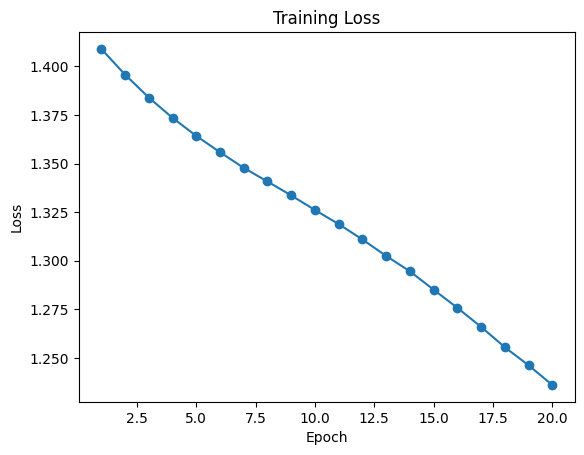


✅ Basic QNN hybrid accuracy: 54.63%


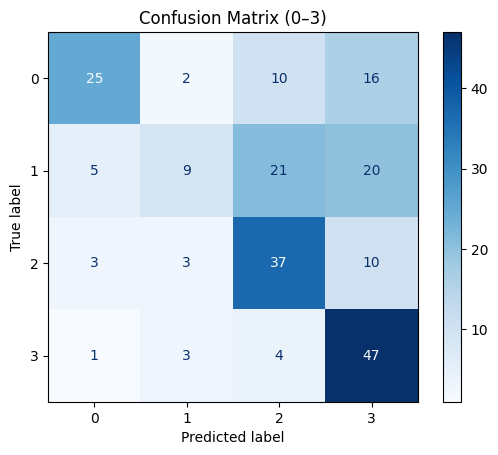

In [15]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Setup
loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs    = 20
losses    = []

# Training loop full batch
for ep in range(1, epochs+1):
    optimizer.zero_grad()
    logits = model(X_train_t)             # [batch,4]
    loss   = loss_fn(logits, y_train_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if ep % 5 == 0:
        print(f"Epoch {ep}/{epochs} — loss {loss.item():.4f}")

# Plot loss
plt.plot(range(1, epochs+1), losses, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss"); plt.show()

# Evaluation
model.eval()
with torch.no_grad():
    preds = model(X_test_t).argmax(dim=1).numpy()

acc = accuracy_score(y_test_np, preds)
print(f"\n✅ Basic QNN hybrid accuracy: {acc*100:.2f}%")

cm = confusion_matrix(y_test_np, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (0–3)")
plt.show()
